# Seminar: Dimensionality reduction

#### Seminar structure:

* SVD (Cingular Value Decomposition) and PCA (Principal Component Analysis) from scratch
* Singular Value Decomposition of an Image.
* The ` Olivetti Faces dataset` component analysis.
* Instrinsic dimensionality estimation.
* Manifold learning.
* Autoencoding.

#### Seminar interactive board: https://www.menti.com/b9jckhyeq5

In [1]:
#linear algebra
import numpy as np
#data structures
import pandas as pd
#ml models
import scipy as sp
import sklearn
#plots
import matplotlib.pyplot as plt
%matplotlib inline
#beautiful plots
import seaborn as sns
import statsmodels.api as sm
#off the warnings
import warnings
warnings.filterwarnings("ignore")

## 1. SVD (Singular Value Decomposition) from the very scratch

The singular value decomposition of a matrix $A$ is the factorization of $A$ into the product of three matrices $A = U\Sigma V^T$ where the columns of $U$ and $V$ are orthonormal and the matrix $\Sigma$ is diagonal with positive real entries. 

$$
A= U\Sigma V^T=
  \begin{matrix}
    \underbrace{\left[\begin{matrix} u_1 &  u_2 &  &  u_r\end{matrix}\right.}& 
    \underbrace{\left.\begin{matrix} u_{r+1} & \dots &   u_m\end{matrix}\right]}\\
    col(A) & null(A^T)
  \end{matrix}
  \begin{bmatrix}
      \sigma_1 & 0 & \dots & 0 & 0 & \dots & 0 \\
         0 & \sigma_2  & \dots & 0 & 0 & \dots & 0 \\
         \dots& & & & &  \\
         0 & 0 & \dots & \sigma_r  & 0 & \dots & 0 \\
         0 & 0 & \dots & 0 & 0 & \dots & 0 \\
         \dots& & & & &  \\
         0 & 0 & \dots & 0 & 0 & \dots & 0 
  \end{bmatrix}
  \begin{bmatrix}
     v_1^T \\  v_2^T \\ \dots \\  v_r^T \\
     v_{r+1}^T \\ \dots \\  v_n^T
  \end{bmatrix}
  \begin{matrix}
    \left.\vphantom{\begin{bmatrix}
       \ v_1^T \\  v_2^T \\ \dots \\ \vect v_r^T 
       \end{bmatrix}}\right\} row(A) \\ 
    \left.\vphantom{\begin{bmatrix}
      \ v_{r+1}^T \\ \dots \\  v_n^T 
    \end{bmatrix}}\right\} null(A)
  \end{matrix}
$$

#### Questions:

1. Is `SVD()` use gradient descent or there is some closed solution?
(Gradients)
2. That is the criterion of good decomposition?
(`Frob norm` of ($A$ - $\hat A$)
3. That is the difference of `PCA` and `SVD`?

#### Here we go:

In [2]:
class MySVD:
    """
    CLass for iterative SVD search
    """
    def __init__(self, tol=1e-10, eigval_thr=1e-10, max_iter=100, random_state=0, verbose=False):
        """
        Arguements:
        - tol: tolerance of difference
        - eigval_thr: theshold for eigvalues
        """
        self.tol = tol
        self.eigval_thr = eigval_thr
        self.max_iter = max_iter
        self.gen = np.random.RandomState(random_state)
        self.verbose = verbose
        
    def _initialize(self, X, n_components):
        self.X = np.array(X)
        assert self.X.ndim == 2
        # singular values
        self.eig_vals = []
        # left singular vectors
        self.eig_vecs_left = []
        # reght singular vectors
        self.eig_vecs_right = []
        n_components = self.X.shape[0] if n_components is None else n_components
        self.n_components = min(self.X.shape[0], self.X.shape[1], n_components)
        
    def _make_step(self, X, a, b):
        new_b = (b + X.T.dot(a) / np.sum(a**2)) / 2
        new_a = (a + X.dot(b) / np.sum(b**2)) / 2

        return new_a, new_b
        
    def __call__(self, X, n_components=None):
        self._initialize(X, n_components)
        # iteretively search for the components
        for n_component in range(self.n_components):
            a = self.gen.rand(self.X.shape[0])
            b = self.gen.rand(self.X.shape[1])
            
            prev_F = np.sum((self.X - a[:, None] * b[None, :])**2)
            delta_F = np.inf
            
            # stop criterion
            for n_iter in range(self.max_iter):
                a, b = self._make_step(self.X, a, b)
                F = np.sum((self.X - a[:, None] * b[None, :])**2)
                delta = prev_F - F
                prev_F = F
                self._print('n_eig = {}, n_iter = {}: delta = {:.5f}, F = {:.5f}.'.format(
                        len(self.eig_vals), n_iter, delta, F))
                if np.abs(delta) <= self.tol:
                    self._print('Frobenius norm equals {}. Stopping iterations for n_eig={}.'.format(
                        F, len(self.eig_vals)))
                    break
                    
            eig_val = np.sum(a**2) * np.sum(b**2) # eigen values XX^T и X^TX
            # stop criterion
            if eig_val < self.eigval_thr:
                self._print('Singular value {} equals {}. Stopping iterations.'.format(
                    len(self.eig_vals) + 1, eig_val))
                break
            self.eig_vals.append(eig_val)
            self.eig_vecs_left.append(a[:, None] / np.sqrt(np.sum(a**2)))
            self.eig_vecs_right.append(b[:, None] / np.sqrt(np.sum(b**2)))
            self.X -= a[:, None] * b[None, :]

        self.U = np.hstack(self.eig_vecs_left)
        self.V = np.hstack(self.eig_vecs_right)
        self.D = np.sqrt(self.eig_vals)
        return self.U, self.D, self.V.T
    
    def _print(self, msg):
        if self.verbose:
            print(msg)

In [3]:
test_array = np.random.randn(10, 3)
u_np, d_np, v_np = np.linalg.svd(test_array, full_matrices=False)
u, d, v = MySVD(verbose=True)(test_array)

assert np.allclose(d, d_np, atol=1e-2)
assert np.allclose(np.dot(np.dot(u, np.diag(d)), v), test_array, atol=1e-2)

n_eig = 0, n_iter = 0: delta = 7.31996, F = 16.99167.
n_eig = 0, n_iter = 1: delta = 5.72518, F = 11.26649.
n_eig = 0, n_iter = 2: delta = 1.13090, F = 10.13558.
n_eig = 0, n_iter = 3: delta = 0.75868, F = 9.37690.
n_eig = 0, n_iter = 4: delta = 0.50107, F = 8.87583.
n_eig = 0, n_iter = 5: delta = 0.33122, F = 8.54461.
n_eig = 0, n_iter = 6: delta = 0.21651, F = 8.32810.
n_eig = 0, n_iter = 7: delta = 0.14005, F = 8.18805.
n_eig = 0, n_iter = 8: delta = 0.08990, F = 8.09816.
n_eig = 0, n_iter = 9: delta = 0.05740, F = 8.04075.
n_eig = 0, n_iter = 10: delta = 0.03653, F = 8.00422.
n_eig = 0, n_iter = 11: delta = 0.02320, F = 7.98102.
n_eig = 0, n_iter = 12: delta = 0.01471, F = 7.96630.
n_eig = 0, n_iter = 13: delta = 0.00933, F = 7.95698.
n_eig = 0, n_iter = 14: delta = 0.00591, F = 7.95107.
n_eig = 0, n_iter = 15: delta = 0.00374, F = 7.94733.
n_eig = 0, n_iter = 16: delta = 0.00237, F = 7.94496.
n_eig = 0, n_iter = 17: delta = 0.00150, F = 7.94346.
n_eig = 0, n_iter = 18: delta = 0.0

In [4]:
class MyPCA:
    def __init__(self, n_components=10, **svd_kwargs):
        self.n_components=n_components
        self.svd = MySVD(**svd_kwargs)
        
    def fit(self, X):
        X = np.array(X)
        self.n_samples, self.n_features = X.shape
        
        # centering
        self.mean_ = X.mean(axis=0)
        X = X - self.mean_[None, :]

        
        # full variance - as a sum of distances to the center
        self.full_variance_ = np.sum(np.mean(X**2, axis=0))
        
        # SVD
        self.U, self.D, self.V = self.svd(X, n_components=self.n_components)
        
        # eigen vectors X^TX in V.T
        self.n_components_ = len(self.D)
        self.components_ = self.V
        
        # the potion of variance eplained
        self.explained_variance_ = self.D**2 / self.n_samples
        self.explained_variance_ratio_ = self.explained_variance_ / self.full_variance_

    def transform(self, X):
        return np.dot(X - self.mean_[None, :], self.components_.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
    
    def recover(self, X):
        return np.dot(X, self.components_) + self.mean_[None, :]

Text(0, 0.5, 'y')

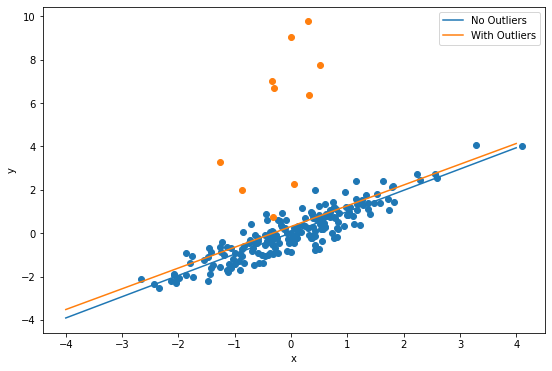

In [5]:
from sklearn.linear_model import LinearRegression

# Clean data
plt.figure(figsize=(9, 6))
np.random.seed(2)
X = np.random.randn(200)
Y = X + np.random.randn(len(X)) * 0.5
model = LinearRegression()
model.fit(X.reshape(-1, 1), Y)
test_x = np.linspace(-4, 4, 100)
predictions = model.predict(test_x.reshape(-1, 1))
plt.plot(X, Y, 'o')
plt.plot(test_x, predictions, label='No Outliers', color='C0')

# Add anomaly
sub_inds = np.random.choice(len(X), 10, replace=False)
XA = X.copy()
YA = Y.copy()
YA[sub_inds] = Y[sub_inds] + np.random.rand(len(sub_inds)) * 10
model.fit(XA.reshape(-1, 1), YA)
predictions = model.predict(test_x.reshape(-1, 1))
plt.plot(test_x, predictions, label='With Outliers')
plt.plot(XA[sub_inds], YA[sub_inds], 'o', color='C1')
plt.legend(loc='best')

plt.xlabel('x')
plt.ylabel('y')

Explained variance: [0.84578759 0.15421241]
Principal components:
First: [0.40260804 0.91537247]
Second: [0.40260804 0.91537247]


(-2.997856560392923, 4.447099727814635, -3.156507481358559, 10.378576493695691)

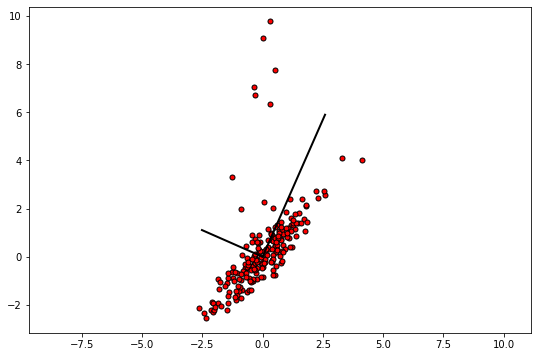

In [6]:
mean = np.array([0.0, 0.0])
cov  = np.array([[1.0, -1.0], 
                [-2.0, 3.0]])

#X = np.random.multivariate_normal(mean, cov, 400)
X = np.stack([XA,YA]).T

pca = MyPCA(n_components=2)
pca.fit(X)

print("Explained variance: {}".format(pca.explained_variance_ratio_))
print("Principal components:")
print("First: {}".format(pca.components_[0]))
print("Second: {}".format(pca.components_[0]))


plt.figure(figsize=(9, 6))

plt.scatter(X[:, 0], X[:, 1], s=25, c='r', marker='o', edgecolor='k')

for var_ratio, direction in zip(pca.explained_variance_ratio_, pca.components_):
    d = 7 * np.sqrt(var_ratio) * direction
    plt.plot([0, d[0]], [0, d[1]], '-k', lw=2)

plt.axis('equal')

##### Watch in the next series (seminar): "Anomaly detection with PCA"

## 2. Singular Value Decomposition of an Image

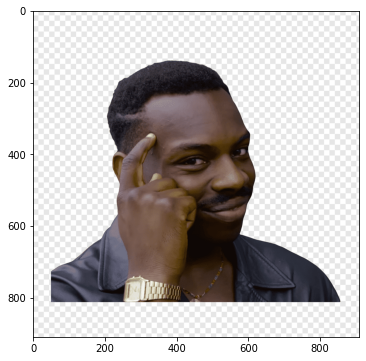

In [7]:
# library for images
from PIL import Image

img = Image.open('think-about-it.png')
imggray = img.convert('LA')
plt.figure(figsize=(9, 6));
plt.imshow(img);

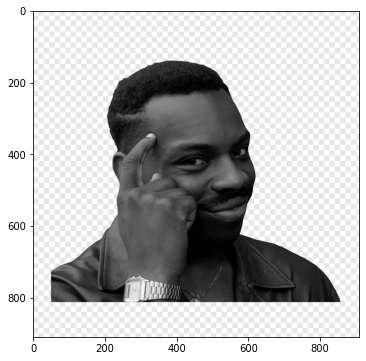

In [8]:
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray');

In [9]:
# you can try this one, yet it converges much longer
# U, sigma, V = MySVD(verbose=False)(imgmat)  
U, sigma, V = np.linalg.svd(imgmat)

In [10]:
len(sigma)

910

Computing an approximation of the image using the first column of  $U$  and first row of  $V$  reproduces the most prominent feature of the image, the light area on top and the dark area on the bottom. The darkness of the arch causes the extra darkness in the middle of the reconstruction. Each column of pixels in this image is a different weighting of the same values,  $u_1$ :

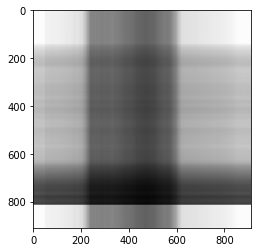

In [11]:
reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='gray');

If we will be able to see the appearance from 2-m component?

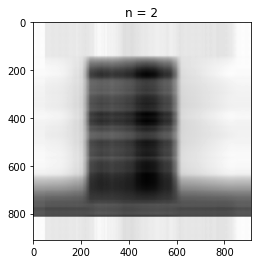

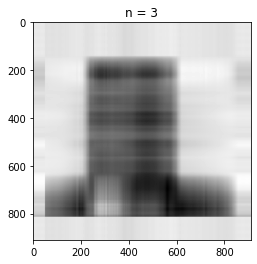

 Soooo clooosee .....


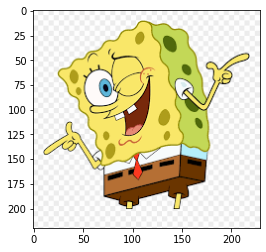

In [12]:
for i in range(2, 4):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()
print(' Soooo clooosee .....')    
plt.imshow(Image.open('Spongebob.png'));

### Ok, how many do we need?

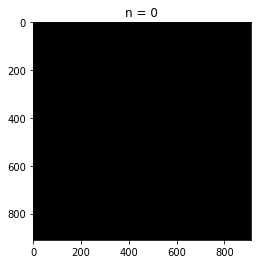

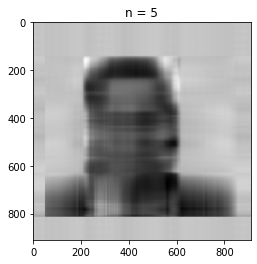

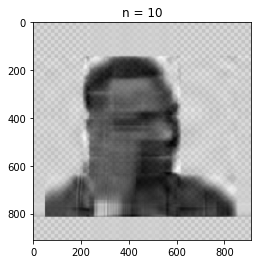

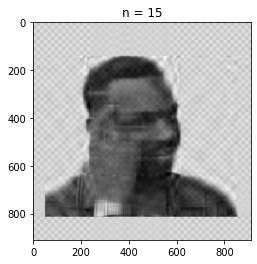

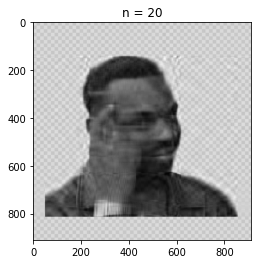

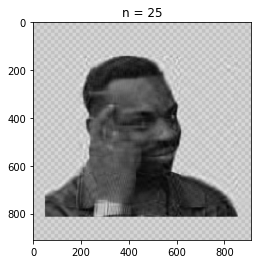

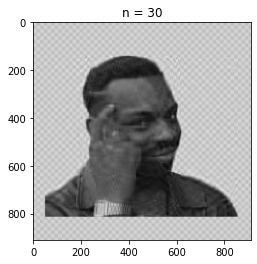

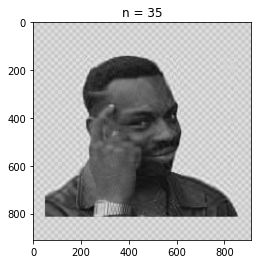

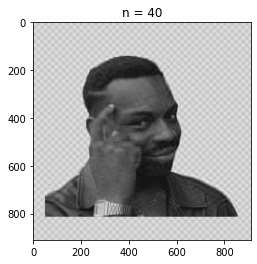

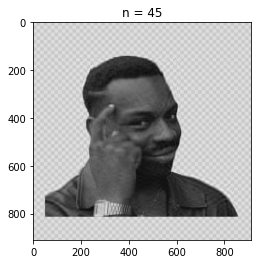

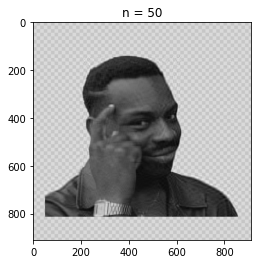

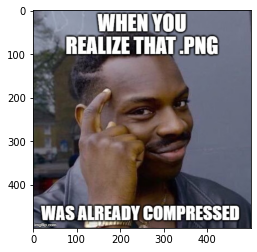

In [13]:
# ok how many do we need
for i in range(0, 51, 5):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show() 
plt.imshow(Image.open('realization.jpg'));

**For my perspective, `[:45]` reconstruction os good enough. Thus we can store less data.**

Questions: 
* What portion of the data we can discard this way?
* Can we estimate the intrinsic dimension of the image through PCA?

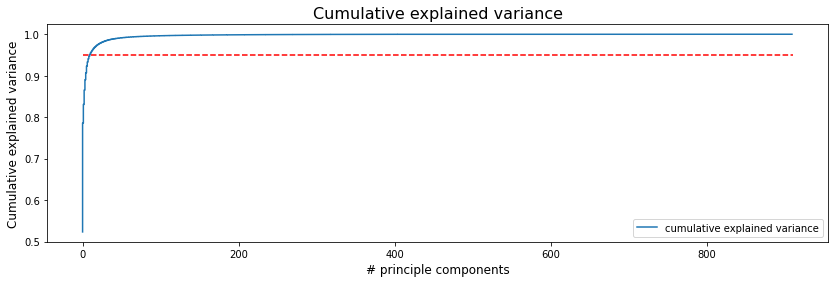

In [14]:
from sklearn.decomposition import PCA
pca = PCA().fit(imgmat)

plt.figure(figsize=(14, 4))

plt.step(range(len(pca.components_)), np.cumsum(pca.explained_variance_ratio_), label='cumulative explained variance')
plt.title('Cumulative explained variance', fontsize=16)
plt.xlabel('# principle components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)

plt.legend(loc='lower right')
plt.hlines(y=0.95, xmin=0, xmax= len(pca.components_), colors='r', linestyles='dashed', label='95% explained variance')
plt.show()

## 3. The `Olivetti Faces dataset` component analysis.

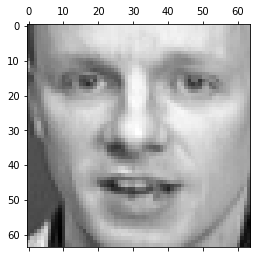

In [15]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from numpy.random import RandomState


data = fetch_olivetti_faces(shuffle=True, random_state= 42 ).data
target = fetch_olivetti_faces(shuffle=True, random_state= 42).target

#data
plt.matshow(data[0].reshape(64,64), cmap='gray');

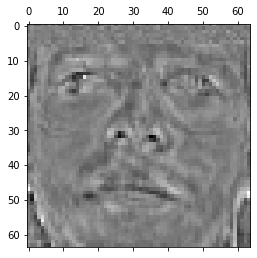

In [16]:
U, sigma, V = np.linalg.svd(data)

plt.matshow(V[:,150].reshape(64,64), cmap='gray');

Questions:
* Who is that criminally looking guy?

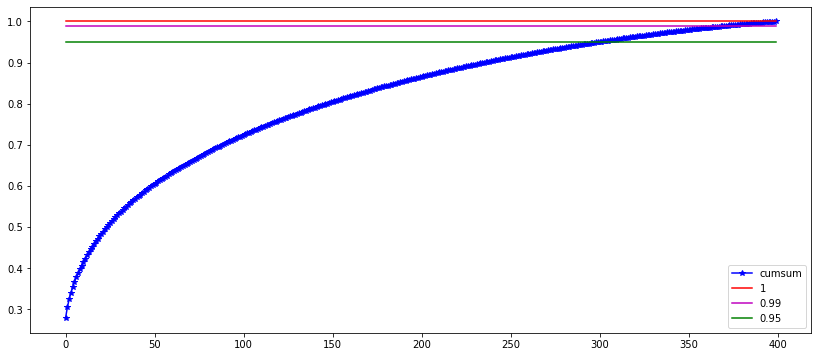

In [17]:
sample_size, sample_dim = np.shape(data);

# how much variance were explained?
plt.figure(figsize = (14,6))
plt.plot(range(sample_size), np.cumsum(sigma) / np.sum(sigma), "-*b", label = 'cumsum')
plt.plot(range(sample_size), [1]*sample_size, "r")
plt.plot(range(sample_size), [0.99]*sample_size, "m")
plt.plot(range(sample_size), [0.95]*sample_size, "g")
plt.legend(['cumsum', '1', '0.99', '0.95']);

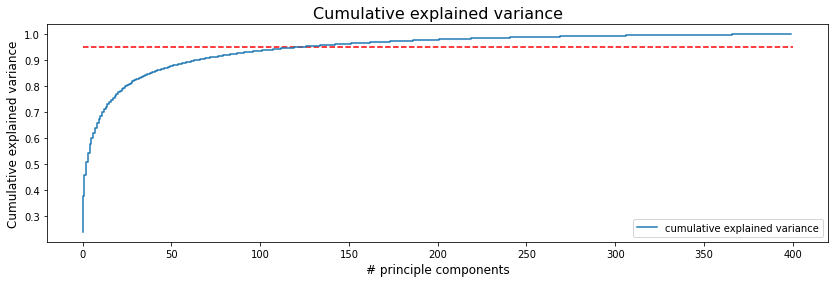

In [18]:
from sklearn.decomposition import PCA
pca = PCA().fit(data)

plt.figure(figsize=(14, 4))

plt.step(range(400), np.cumsum(pca.explained_variance_ratio_), label='cumulative explained variance')
plt.title('Cumulative explained variance', fontsize=16)
plt.xlabel('# principle components', fontsize=12)
plt.ylabel('Cumulative explained variance', fontsize=12)

plt.legend(loc='lower right')
plt.hlines(y=0.95, xmin=0, xmax=len(pca.components_), colors='r', linestyles='dashed', label='95% explained variance')
plt.show()

In [19]:
from matplotlib import offsetbox
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_embedding(X, y, images_small=None, title=None):
    """
    Nice plot on first two components of embedding with Offsets.
    
    """
    # take only first two columns
    X = X[:, :2]
    # scaling
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure(figsize=(13,8))
    ax = plt.subplot(111)
    
    for i in range(X.shape[0] - 1):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.RdGy(y[i]),
                 fontdict={'weight': 'bold', 'size': 12})
        if images_small is not None:
            imagebox = OffsetImage(images_small[i], zoom=.4, cmap = 'gray')
            ab = AnnotationBbox(imagebox, (X[i, 0], X[i, 1]),
                xycoords='data')                                  
            ax.add_artist(ab)
    
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-1:
                # don't show points that are too close
                continue
    if title is not None:
        plt.title(title)

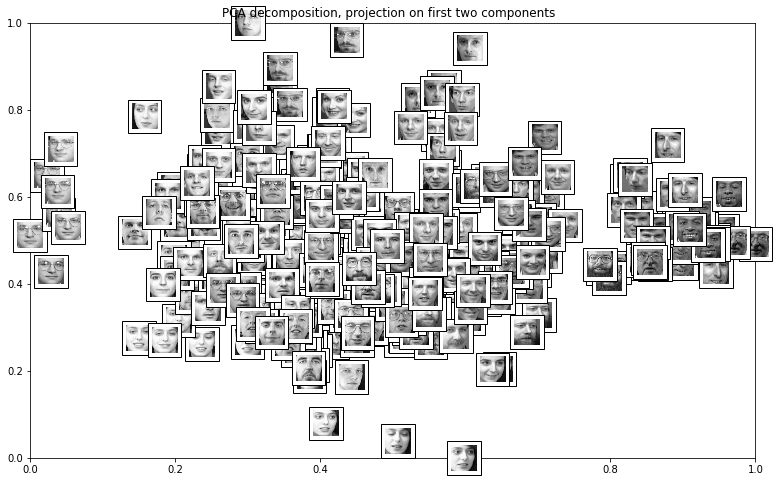

In [20]:
X_projected = PCA(400).fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "PCA decomposition, projection on first two components  ")

If I will change the number of components in here `PCA(100)` will it change the manifold?

## 4. Estimation of intrinsic dimension

From the paper: 


*There is a consensus in the high-dimensional data analysis community that the only reason any methods work in very high dimensions is that, in fact, the data are not truly high-dimensional. Rather, they are embedded in a high-dimensional space,
but can be efficiently summarized in a space of a much lower dimension, such as a nonlinear manifold.* 

*Then one can reduce dimension without losing much information for many types of real-life high-dimensional data, such as images, and avoid many of the “curses of dimensionality”. Learning these data manifolds can improve
performance in classification and other applications, but if the data structure is
complex and nonlinear, dimensionality reduction can be a hard problem.*

#####  NIPS 2004: https://papers.nips.cc/paper/2577-maximum-likelihood-estimation-of-intrinsic-dimension.pdf

In [21]:
"""
Implementation of 'Maximum Likelihood Estimation of Intrinsic Dimension' by Elizaveta Levina and Peter J. Bickel
 
how to use
----------
 
The goal is to estimate intrinsic dimensionality of data, the estimation of dimensionality is scale dependent
(depending on how much you zoom into the data distribution you can find different dimesionality), so they
propose to average it over different scales, the interval of the scales [k1, k2] are the only parameters of the algorithm.
 
This code also provides a way to repeat the estimation with bootstrapping to estimate uncertainty.
 
Here is one example with swiss roll :
 
from sklearn.datasets import make_swiss_roll
X, _ = make_swiss_roll(1000)
 
k1 = 10 # start of interval(included)
k2 = 20 # end of interval(included)
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             X, 
                             mode='bootstrap', 
                             nb_iter=500, # nb_iter for bootstrapping
                             verbose=1, 
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)
# the shape of intdim_k_repeated is (nb_iter, size_of_interval) where 
# nb_iter is number of bootstrap iterations (here 500) and size_of_interval
# is (k2 - k1 + 1).
 
"""
# from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
 
def intrinsic_dim_sample_wise(X, k=5):
    neighb = NearestNeighbors(n_neighbors=k+1).fit(X)
    dist, ind = neighb.kneighbors(X) # distances between the samples and points
    dist = dist[:, 1:] # the distance between the first points to first points (as basis ) equals zero
    # the first non trivial point
    dist = dist[:, 0:k]# including points k-1
    assert dist.shape == (X.shape[0], k) # requirments are there is no equal points
    assert np.all(dist > 0)
    d = np.log(dist[:, k - 1: k] / dist[:, 0:k-1]) # dinstance betveen the bayeasan statistics
    d = d.sum(axis=1) / (k - 2)
    d = 1. / d
    intdim_sample = d
    return intdim_sample
 
def intrinsic_dim_scale_interval(X, k1=10, k2=20):
    X = pd.DataFrame(X).drop_duplicates().values # remove duplicates in case you use bootstrapping
    intdim_k = []
    for k in range(k1, k2 + 1): # in order to reduse the noise by eliminating of the nearest neibours 
        m = intrinsic_dim_sample_wise(X, k).mean()
        intdim_k.append(m)
    return intdim_k
 
def repeated(func, X, nb_iter=100, random_state=None, mode='bootstrap', **func_kw):
    if random_state is None:
        rng = np.random
    else:
        rng = np.random.RandomState(random_state)
    nb_examples = X.shape[0]
    results = []
 
    iters = range(nb_iter) 
    for i in iters:
        if mode == 'bootstrap':# and each point we want to resample with repeating points to reduse the errors 
            #232 111 133 
            Xr = X[rng.randint(0, nb_examples, size=nb_examples)]
        elif mode == 'shuffle':
            ind = np.arange(nb_examples)
            rng.shuffle(ind)
            Xr = X[ind]
        elif mode == 'same':
            Xr = X
        else:
            raise ValueError('unknown mode : {}'.format(mode))
        results.append(func(Xr, **func_kw))
    return results

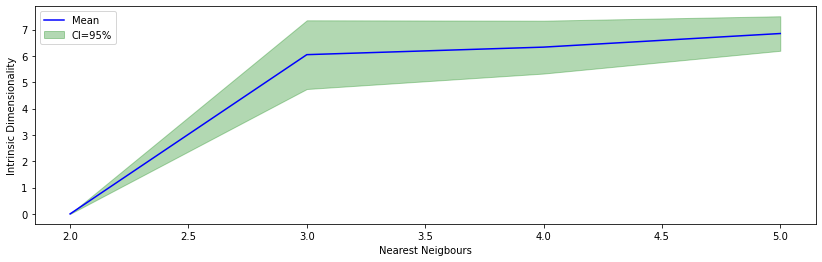

In [22]:
import warnings
warnings.filterwarnings("ignore")

k1 = 1 # start of interval(included)
k2 = 5 # end of interval(included)
nb_iter = 3 # more iterations more accuracy
# intrinsic_dim_scale_interval gives better estimation
intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                             data, 
                             mode='bootstrap', 
                             nb_iter=nb_iter, # nb_iter for bootstrapping
                             k1=k1, k2=k2)
intdim_k_repeated = np.array(intdim_k_repeated)

x = np.arange(k1, k2+1)

plt.figure(figsize=(14, 4))
plt.plot(x, np.mean(intdim_k_repeated, axis=0), 'b', label='Mean') # it is the mean walue
plt.fill_between(x, 
                 np.mean(intdim_k_repeated, axis=0) - 
                 2 * np.std(intdim_k_repeated, axis=0),
                 np.mean(intdim_k_repeated, axis=0) + 
                 2 * np.std(intdim_k_repeated, axis=0),
                 alpha=0.3,
                 label='CI=95%',
                 color='g')
plt.xlabel("Nearest Neigbours")
plt.ylabel("Intrinsic Dimensionality")
plt.legend()
plt.show()

## 5. Manifold learning  

It is big part of research on the application of geometry and in particular differential geometry to machine learning. If you are interested - next term it will be course by **Prof. Bernstein** - you are welcomed. 

We are going to touch a couple popular algorithms from: https://scikit-learn.org/stable/modules/manifold.html

The manifold learning methods also assumes nono-linear algorithms for dimensionality reduction.

Questions:
* Is `PCA` linear?
* Can we compose non-linear `PCA` from the linear?

Principal Component Analysis (PCA), Independent Component Analysis, Linear Discriminant Analysis, and others. These algorithms define specific rubrics to choose an good linear projection of the data. 

These methods can be powerful, but often miss important non-linear structure in the data.


**Lets go with some other liner method : Independent Component Analysis `ICA`.** 
FastICA algorithm: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

<img src="https://cf2.ppt-online.org/files2/slide/c/CarDgVY6t91bypGImvqBcR3OdAjWhFTZ2JQxL4ofM/slide-6.jpg" alt="Drawing" style="width: 700px;" />

In [23]:
# let's leave 20 peaple from faces to get more comprehencible visualisation

data = fetch_olivetti_faces(shuffle=True, random_state= 42 ).data
target = fetch_olivetti_faces(shuffle=True, random_state= 42).target


data = data[target <20]
target = target[target <20]

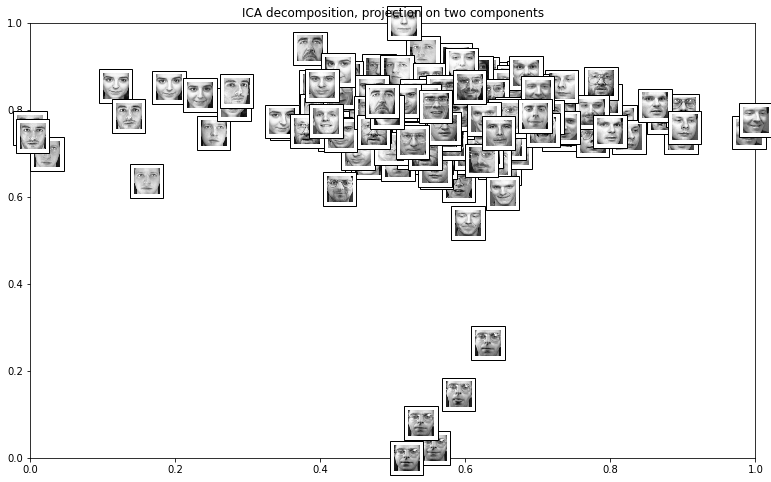

In [24]:
from sklearn.decomposition import FastICA 

X_projected = FastICA(20, random_state = 42).fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "ICA decomposition, projection on two components")

Will the decomposition change with the `n_components` changed?

**The most popular nonlinear algorithms: tSNE,  MDS, Isomap**

t-SNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

1. For each data point $x_i$ we’ll center a Gaussian distribution over that point. Then we measure the density of all points $x_j$ under that Gaussian distribution. Then renormalize for all points. This gives us a set of probabilities $P_{ij}$ for all points in higher dimentional space.

2. Get the second set of probablities $Q_{ij}$ for Cauchy distribution (with is Students t-distribution with one degree of freedom), which allow for better modeling of far apart distances, becouse of heavier tails.

3. Map these two sets of probabilities ($ P_{ij}; Q_{ij}$)to each other, optimiing KL-divergence.

Where Kullback–Leibler divergence can be defined as 

$$ D_{KL} (P || Q) = \sum P(x) log(\frac{P(x)}{Q(x)})$$

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.056s...
[t-SNE] Computed neighbors for 200 samples in 0.285s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 4.201302
[t-SNE] Computed conditional probabilities in 0.070s
[t-SNE] Iteration 50: error = 50.8396034, gradient norm = 0.0000001 (50 iterations in 0.101s)
[t-SNE] Iteration 100: error = 50.8329811, gradient norm = 0.0000000 (50 iterations in 0.063s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 50.832981
[t-SNE] Iteration 150: error = 0.6407382, gradient norm = 0.0116662 (50 iterations in 0.064s)
[t-SNE] Iteration 200: error = 0.4326170, gradient norm = 0.0015477 (50 iterations in 0.050s)
[t-SNE] Iteration 250: error = 0.4133429, gradient norm = 0.0004569 (50 iterations in 0.048s)
[t-SNE] Iteration 300: error = 0.4076792, gradient norm = 0.0003030 (50 iterations in 0.062s)
[t-SNE] Iterati

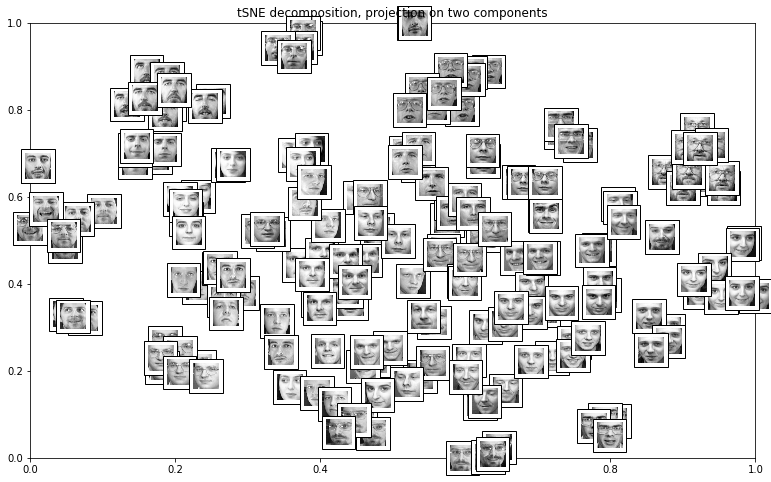

In [25]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, n_iter = 1000, metric='euclidean', learning_rate= 10, verbose=2, random_state = 42)

X_projected = tsne.fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "tSNE decomposition, projection on two components")

### Isometric Mapping (Isomap)

Isomap can be viewed as an extension of Multi-dimensional Scaling (MDS) or Kernel PCA. Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points. Goes in three stages:

1. **Nearest neighbor search**. 

2. **Shortest-path graph search.**

3. **Partial eigenvalue decomposition**. The embedding is encoded in the eigenvectors corresponding to the  largest eigenvalues of the  isomap kernel.

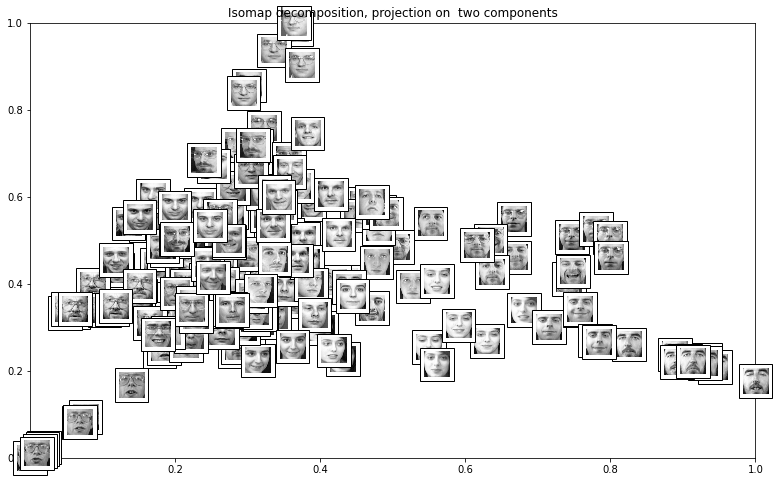

In [26]:
from sklearn.manifold import Isomap

X_projected = Isomap(n_components=2).fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "Isomap decomposition, projection on  two components")

### Multi-dimensional Scaling (MDS)

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

*Modern Multidimensional Scaling - Theory and Applications, Borg, I.; Groenen P. Springer Series in Statistics (1997)*

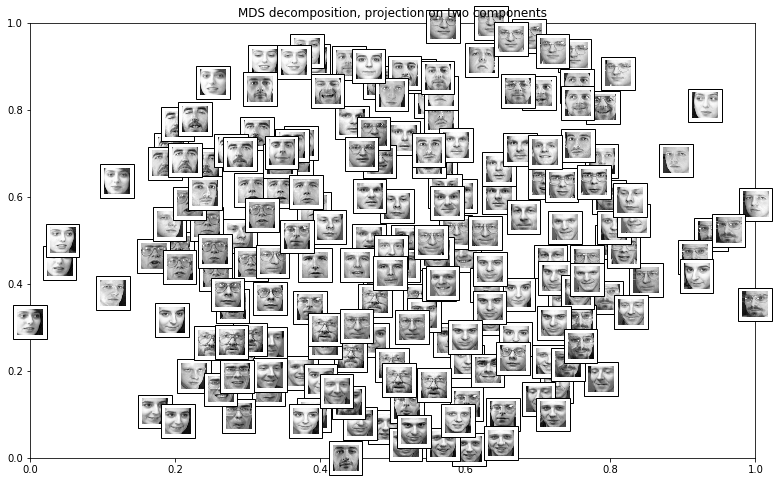

In [27]:
from sklearn.manifold import MDS

X_projected = MDS(n_components=2).fit_transform(data)
data_pic = data.reshape((-1, 64, 64))
plot_embedding(X_projected, target, data_pic, "MDS decomposition, projection on two components")